In [1]:
%matplotlib inline

# Segmentation


Segmentation is the division of an image into "meaningful" regions. If you've seen The Terminator, you've seen image segmentation:

<img src="../2014-scipy/images/terminator-vision.png" width="700px"/>

In `scikit-image`, you can find segmentation functions in the `segmentation` package, with one exception: the `watershed` function is in `morphology`, because it's a bit of both. We'll use watershed and region boundary agglomeration. Functions such as `segmentation.slic` are useful for images in which the objects you want to segment have different colors. We won't cover them here but you should be aware they exist.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'gray'

## Segmenting with filters

In many images, the contrast between regions is not sufficient to distinguish them, but there is a clear boundary between them. Using an edge detector on these images, followed by a *watershed*, often gives very good segmentation. For example, look at the output of the Sobel filter on the coins image:

In [3]:
from skimage import data
from skimage import filters
from matplotlib import cm

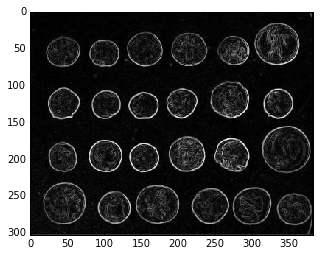

In [4]:
coins = data.coins()
edges = filters.sobel(coins)

plt.imshow(edges, cmap='gray');

The *watershed algorithm* finds the regions between these edges. It does so by envisioning the pixel intensity as height on a topographic map. It then "floods" the map from the bottom up, starting from seed points. These flood areas are called "watershed basins" and when they meet, they form the image segmentation.

Let's look at a one-dimensional example:

In [5]:
from skimage.morphology import watershed
from scipy import ndimage as ndi

x = np.arange(12)
y = np.array([1, 0, 1, 2, 1, 3, 2, 0, 2, 4, 1, 0])

seeds = ndi.label(y == 0)[0]
seed_positions = np.argwhere(seeds)[:, 0]

print("Seeds:", seeds)
print("Seed positions:", seed_positions)

Seeds: [0 1 0 0 0 0 0 2 0 0 0 3]
Seed positions: [ 1  7 11]


In [6]:
result = watershed(y, seeds)
print(result)

[1 1 1 1 1 2 2 2 2 3 3 3]


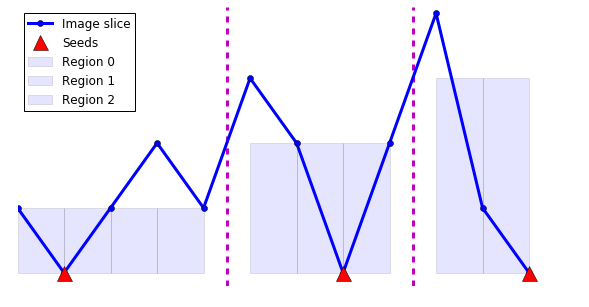

In [7]:
# You can ignore the code below--it's just
# to make a pretty plot of the results.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y, '-o', label='Image slice', linewidth=3)
ax.plot(seed_positions, np.zeros_like(seed_positions), 'r^',
        label='Seeds', markersize=15)

for n, label in enumerate(np.unique(result)):
    mask = (result == label)
    ax.bar(x[mask][:-1], result[mask][:-1],
           width=1, label='Region %d' % n,
           alpha=0.1)

ax.vlines(np.argwhere(np.diff(result)) + 0.5, -0.2, 4.1, 'm',
          linewidth=3, linestyle='--')

ax.legend(loc='upper left', numpoints=1)
ax.axis('off')
ax.set_ylim(-0.2, 4.1);

Let's find some seeds for `coins`. First, we compute the *distance transform* of a thresholded version of `edges`:

0.143982851338


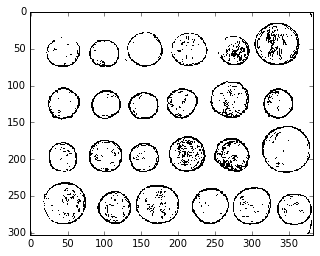

In [8]:
threshold = filters.threshold_otsu(edges)
print(threshold)
# Euclidean distance transform
# How far do we have to travel from a non-edge to find an edge?
non_edges = (edges < threshold)
plt.imshow(non_edges)

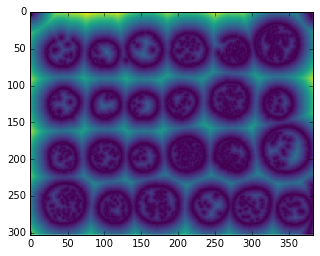

In [9]:
distance_from_edge = ndi.distance_transform_edt(non_edges)

plt.imshow(distance_from_edge, cmap='viridis');

Then, we find the *peaks* in that image--the background points furthest away from any edges--which will act as the seeds.

In [10]:
from skimage import feature
peaks = feature.peak_local_max(distance_from_edge, min_distance=10)
print("Peaks shape:", peaks.shape)

Peaks shape: (83, 2)


(-0.5, 383.5, 302.5, -0.5)

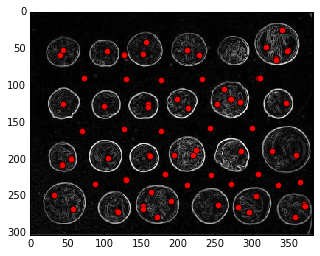

In [11]:
peaks_image = np.zeros(coins.shape, np.bool)
peaks_image[tuple(np.transpose(peaks))] = True
seeds, num_seeds = ndi.label(peaks_image)

plt.imshow(edges, cmap='gray')
plt.plot(peaks[:, 1], peaks[:, 0], 'ro');
plt.axis('image')

We are now ready to perform the watershed:

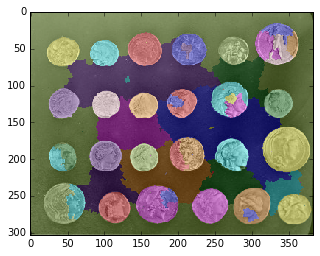

In [12]:
ws = watershed(edges, seeds)

from skimage import color
plt.imshow(color.label2rgb(ws, coins));

## Examining the resulting segmentation

That's pretty good! Some coins are perfectly segmented, with only one missing. We can't do much about the missing one (yet), but we can [*merge regions*](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_boundary_merge.html#example-segmentation-plot-boundary-merge-py) to fix the remaining coins, and the background. For that we need a *region adjacency graph*, or RAG.

In [13]:
from skimage.future import graph

Because *mean boundary agglomeration* won't be available until scikit-image 0.13, we have to *monkey patch* the RAG class to use it. 

In [14]:
def merge_nodes(self, src, dst, weight_func=None, in_place=True,
                extra_arguments=[], extra_keywords={}):
    src_nbrs = set(self.neighbors(src))
    dst_nbrs = set(self.neighbors(dst))
    neighbors = (src_nbrs | dst_nbrs) - set([src, dst])

    if in_place:
        new = dst
    else:
        new = self.next_id()
        self.add_node(new)

    for neighbor in neighbors:
        data = weight_func(self, src, new, neighbor, *extra_arguments,
                           **extra_keywords)
        self.add_edge(neighbor, new, attr_dict=data)

    self.node[new]['labels'] = (self.node[src]['labels'] +
                                self.node[dst]['labels'])
    self.remove_node(src)

    if not in_place:
        self.remove_node(dst)

    return new

graph.RAG.merge_nodes = merge_nodes

Now we can make a RAG that will be mergeable:

In [15]:
g = graph.rag_boundary(ws, edges)

g is now a *graph* in which each region is a node, and each node links to that regions neighbors. The edges have hold properties about the boundary between the corresponding region:

{56: {'weight': 0.36249957227988966, 'count': 50}, 9: {'weight': 0.336771458857067, 'count': 107}, 55: {'weight': 0.33847313851123995, 'count': 100}, 33: {'weight': 0.35003531687802925, 'count': 83}}


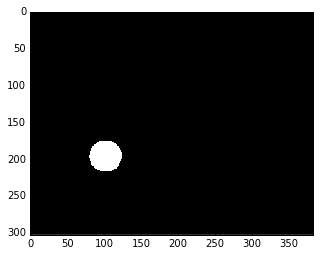

In [16]:
plt.imshow(ws == 45)
print(g[45])

{9: {'weight': 0.20908660164945722, 'count': 132}, 44: {'weight': 0.088559227067871546, 'count': 129}, 46: {'weight': 0.060254901966819326, 'count': 6}}


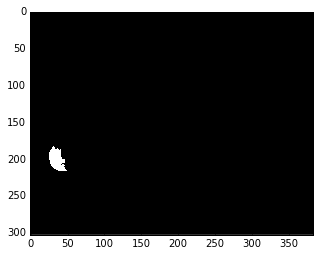

In [17]:
plt.imshow(ws == 47)
print(g[47])

Look at the `skimage.future.graph.merge_hierarchical` API. It's still being worked on. That's why it's in `future`, but the future is here! Start using it now and send us feedback!

In [18]:
from skimage.future import graph

graph.merge_hierarchical?

Note that it needs both a merge function and a weight function, which together define how merging nodes affects the graph. In our case, we want any edges to reflect the mean of the pixels at their boundary.

In [19]:
from skimage.future import graph

def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']
    
    count = count_src + count_dst
    weighted_mean = (count_src * weight_src +
                     count_dst * weight_dst) / count

    return {'count': count, 'weight': weighted_mean}


def do_nothing(*args, **kwargs):
    pass

Now we can use these functions to merge the the nodes of the graph, one after the other:

In [ ]:
seg_coins = graph.merge_hierarchical(ws, g, thresh=0.155, rag_copy=True,
                                     in_place_merge=True,
                                     merge_func=do_nothing,
                                     weight_func=weight_boundary)

Let's look at the result:

In [ ]:
from skimage import segmentation
plt.imshow(segmentation.mark_boundaries(coins, seg_coins))

We're missing a coin, but otherwise it's perfect! Mean boundary agglomeration, as this procedure is called, is simple but powerful!

## <span class="exercise">Exercise: The Seeds of Doubt</span>

Watershed combined with region agglomeration makes a very good segmentation, but we missed a coin. How can you improve this?

We missed a seed, so think of a few other ways to place seeds of an image, or to get a finer segmentation at the start. Here's a couple of ideas:
- find peaks in a Gaussian-smoothed image of the coins, and combine those with our original seeds.
- use a different segmentation algorithm from `watershed`, such as `segmentation.felzenszwalb` or `segmentation.slic`, and find its intersection with watershed using `segmentation.join_segmentations`.